# Translation with a Sequence to Sequence Network and Attention

英語から日本語への翻訳を行えるネットワークを構築する。
https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

コーパスは以下のものを使用する。
https://github.com/odashi/small_parallel_enja

# importとCUDAの確認

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
device

device(type='cuda')

In [3]:
# 入出力単語数
MAX_LENGTH = 18

# Attentionの可視化で日本語フォントを使う

In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

plt.rcParams['font.family'] = 'Ume Gothic O5'
plt.rcParams['font.size'] = 10

# データをちょいと確認

In [5]:
! head -n 5 data/small_parallel_enja/train.en

i can 't tell who will arrive first .
many animals have been destroyed by men .
i 'm in the tennis club .
emi looks happy .
please bear this fact in mind .


In [6]:
! head -n 5 data/small_parallel_enja/train.ja

誰 が 一番 に 着 く か 私 に は 分か り ま せ ん 。
多く の 動物 が 人間 に よ っ て 滅ぼ さ れ た 。
私 は テニス 部員 で す 。
エミ は 幸せ そう に 見え ま す 。
この 事実 を 心 に 留め て お い て 下さ い 。


# Lang（トークナイザー）を作る

In [7]:
PAD_token = 0
SOS_token = 1
EOS_token = 2


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS"}
        self.n_words = 3  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [8]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines1 = open('data/small_parallel_enja/train.{}'.format(lang1), encoding='utf-8').\
        read().strip().split('\n')
    lines2 = open('data/small_parallel_enja/train.{}'.format(lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs
    pairs = [[s1, s2] for (s1, s2) in zip(lines1, lines2)]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

# データの準備

In [9]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('en', 'ja', False)
print(random.choice(pairs))

Reading lines...
Read 50000 sentence pairs
Counting words...
Counted words:
en 6637
ja 8777
['those children went away , singing a song .', 'その 子供 たち は 歌 い ながら 去 っ て 行 っ た 。']


In [10]:
# train / test split
from sklearn.model_selection import train_test_split
train_pairs, test_pairs = train_test_split(pairs, test_size=0.2)

In [11]:
def tensorFromSentence(lang, sentence):
    length = len(sentence.split(' '))
    indexes = [lang.word2index[word] for word in sentence.split(' ')]
    return indexes + [EOS_token] + [0] * (MAX_LENGTH - length - 1), length + 1

# バッチを作成するジェネレーター

In [12]:
import random

def generate_batch(pairs, batch_size=200, shuffle=True):
    
    random.shuffle(pairs)
    
    for i in range(len(pairs) // batch_size):
        batch_pairs = pairs[batch_size*i:batch_size*(i+1)]

        input_batch = []
        target_batch = []
        input_lens = []
        target_lens = []
        for input_seq, target_seq in batch_pairs:
            input_seq, input_length = tensorFromSentence(input_lang, input_seq)
            target_seq, target_length = tensorFromSentence(output_lang, target_seq)

            input_batch.append(input_seq)
            target_batch.append(target_seq)
            input_lens.append(input_length)
            target_lens.append(target_length)

        input_batch = torch.tensor(input_batch, dtype=torch.long, device=device)
        target_batch = torch.tensor(target_batch, dtype=torch.long, device=device)
        input_lens = torch.tensor(input_lens)
        target_lens = torch.tensor(target_lens)
        
        # sort
        input_lens, sorted_idxs = input_lens.sort(0, descending=True)
        input_batch = input_batch[sorted_idxs].transpose(0, 1)
        input_batch = input_batch[:input_lens.max().item()]
        
        target_batch = target_batch[sorted_idxs].transpose(0, 1)
        target_batch = target_batch[:target_lens.max().item()]
        target_lens = target_lens[sorted_idxs]
        
        yield input_batch, input_lens, target_batch, target_lens


# EncoderとDecoderの作成と簡単なテスト

In [13]:
import torch
from torch import nn
import torch.nn.functional as F


class EncoderRNN(nn.Module):
    def __init__(self, input_size, emb_size, hid_size, pad_token=0):
        super(EncoderRNN, self).__init__()
        self.embedding_size = emb_size
        self.hidden_size = hid_size

        self.embedding = nn.Embedding(input_size, emb_size, padding_idx=pad_token)
        self.lstm = nn.LSTM(input_size=emb_size,
                            hidden_size=hid_size,
                            bidirectional=True)
        self.linear_h = nn.Linear(hid_size * 2, hid_size)
        self.linear_c = nn.Linear(hid_size * 2, hid_size)

    def forward(self, input_batch, input_lens):
        """
        :param input_batch: (s, b)
        :param input_lens: (b)

        :returns (s, b, 2h), ((1, b, h), (1, b, h))
        """

        batch_size = input_batch.shape[1]

        embedded = self.embedding(input_batch)  # (s, b) -> (s, b, h)
        output, (hidden_h, hidden_c) = self.lstm(embedded)

        hidden_h = hidden_h.transpose(1, 0)  # (2, b, h) -> (b, 2, h)
        hidden_h = hidden_h.reshape(batch_size, -1)  # (b, 2, h) -> (b, 2h)
        hidden_h = F.dropout(hidden_h, p=0.5, training=self.training)
        hidden_h = self.linear_h(hidden_h)  # (b, 2h) -> (b, h)
        hidden_h = F.relu(hidden_h)
        hidden_h = hidden_h.unsqueeze(0)  # (b, h) -> (1, b, h)

        hidden_c = hidden_c.transpose(1, 0)
        hidden_c = hidden_c.reshape(batch_size, -1)  # (b, 2, h) -> (b, 2h)
        hidden_c = F.dropout(hidden_c, p=0.5, training=self.training)
        hidden_c = self.linear_c(hidden_c)
        hidden_c = F.relu(hidden_c)
        hidden_c = hidden_c.unsqueeze(0)  # (b, h) -> (1, b, h)

        return output, (hidden_h, hidden_c)  # (s, b, 2h), ((1, b, h), (1, b, h))


class DecoderRNN(nn.Module):
    def __init__(self, emb_size, hidden_size, output_size, pad_token=0):
        super(DecoderRNN, self).__init__()

        self.embedding = nn.Embedding(output_size, emb_size, padding_idx=pad_token)
        self.lstm = nn.LSTMCell(emb_size, hidden_size)
        self.out_w = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        """
        :param input: (b)
        :param hidden: ((b,h), (b,h))
        :return: (b,o), (b,h)
        """

        embedded = self.embedding(input)  # (b) -> (b,e)
        decoder_output, hidden = self.lstm(embedded, hidden)  # (b,e),((b,h),(b,h)) -> (b,h),((b,h),(b,h))
        output = self.out_w(decoder_output)  # (b,h) -> (b,o)
        output = F.log_softmax(output, dim=1)

        return output, hidden  # (b,o), (b,h)


class AttnDecoderRNN1(nn.Module):
    def __init__(self, emb_size, hidden_size, output_size, max_length=20):
        super(AttnDecoderRNN1, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.max_length = max_length

        self.embedding = nn.Embedding(output_size, emb_size)
        self.attn = nn.Linear(emb_size+2*hidden_size, max_length)
        self.attn_combine = nn.Linear(emb_size+2*hidden_size, hidden_size)

        self.lstm = nn.LSTMCell(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden, encoder_outputs):
        """
        :param input: (b)
        :param hidden: ((b, h), (b, h))
        :param encoder_outputs: (il, b, 2h)
        :return: (b,o), ((b,h),(b,h)), (b,il)
        """
        input_length = encoder_outputs.shape[0]
        #padding
        encoder_outputs = torch.cat([
            encoder_outputs,
            torch.zeros(
                self.max_length - input_length,
                encoder_outputs.shape[1],
                encoder_outputs.shape[2],
                device=device
            )
        ], dim=0)  # (il,b,2h), (ml-il,b,2h) -> (ml,b,2h)
        drop_encoder_outputs = F.dropout(encoder_outputs, p=0.1, training=self.training)
        
        # embedding
        embedded = self.embedding(input)  # (b) -> (b,e)
        embedded = F.dropout(embedded, p=0.5, training=self.training)
    
        emb_hidden = torch.cat([embedded, hidden[0], hidden[1]], dim=1)  # (b,e),((b,h),(b,h)) -> (b,e+2h)

        attn_weights = self.attn(emb_hidden)  # (b,e+2h) -> (b,ml)
        attn_weights = F.softmax(attn_weights, dim=1)

        attn_applied = torch.bmm(
            attn_weights.unsqueeze(1),  # (b, 1, ml)
            drop_encoder_outputs.transpose(0, 1)  # (b, ml, 2h)
        )  # -> (b, 1, 2h)

        attn_applied = F.dropout(attn_applied, p=0.1, training=self.training)
        output = torch.cat((embedded, attn_applied.squeeze(1)), 1)  # ((b,e),(b,2h)) -> (b,e+2h)
        output = self.attn_combine(output)  # (b,e+2h) -> (b,h)
        output = F.dropout(output, p=0.5, training=self.training)

        output = F.relu(output)
        hidden = self.lstm(output, hidden)  # (b,h),((b,h),(b,h)) -> (b,h)((b,h),(b,h))

        output = F.log_softmax(self.out(hidden[0]), dim=1)  # (b,h) -> (b,o)
        return output, hidden, attn_weights  # (b,o),(b,h),(b,il)


class AttnDecoderRNN2(nn.Module):
    def __init__(self, emb_size, hidden_size, attn_size, output_size, pad_token=0):
        super(AttnDecoderRNN2, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.embedding = nn.Embedding(output_size, emb_size, padding_idx=pad_token)
        self.lstm = nn.LSTMCell(emb_size, hidden_size)

        self.score_w = nn.Linear(2*hidden_size, 2*hidden_size)
        self.attn_w = nn.Linear(4*hidden_size, attn_size)
        self.out_w = nn.Linear(attn_size, output_size)

    def forward(self, input, hidden, encoder_outputs):
        """
        :param: input: (b)
        :param: hidden: ((b,h),(b,h))
        :param: encoder_outputs: (il,b,2h)

        :return: (b,o), ((b,h),(b,h)), (b,il)
        """
        
        embedded = self.embedding(input)  # (b) -> (b,e)
        embedded = F.dropout(embedded, p=0.5, training=self.training)
        
        hidden = self.lstm(embedded, hidden)  # (b,e),((b,h),(b,h)) -> ((b,h),(b,h))
        decoder_output = torch.cat(hidden, dim=1)  # ((b,h),(b,h)) -> (b,2h)
        decoder_output = F.dropout(decoder_output, p=0.5, training=self.training)

        # score
        score = self.score_w(decoder_output)  # (b,2h) -> (b,2h)
        scores = torch.bmm(
            encoder_outputs.transpose(0, 1),  # (b,il,2h)
            score.unsqueeze(2)  # (b,2h,1)
        )  # (b,il,1)
        attn_weights = F.softmax(scores, dim=1)  # (b,il,1)

        # context
        context = torch.bmm(
            attn_weights.transpose(1, 2),  # (b,1,il)
            encoder_outputs.transpose(0, 1)  # (b,il,2h)
        )  # (b,1,2h)
        context = context.squeeze(1)  # (b,1,2h) -> (b,2h)

        concat = torch.cat((context, decoder_output), dim=1)  # ((b,2h),(b,2h)) -> (b,4h)
        #concat = F.dropout(concat, p=0.5, training=self.training)

        attentional = self.attn_w(concat)  # (b,4h) -> (b,a)
        attentional = F.tanh(attentional)
        #attentional = F.dropout(attentional, p=0.5, training=self.training)

        output = self.out_w(attentional)  # (b,a) -> (b,o)
        output = F.log_softmax(output, dim=1)

        return output, hidden, attn_weights.squeeze(2)  # (b,o), ((b,h),(b,h)), (b,il)


In [14]:
batch_size = 10
emb_size = 8
hid_size = 12
attn_size = 9

# test encoder
test_encoder = EncoderRNN(input_lang.n_words, emb_size, hid_size).to(device)
for input_batch, input_lens, output_batch, output_lens in generate_batch(train_pairs, batch_size):
    break
input_batch.shape, input_lens.shape

(torch.Size([11, 10]), torch.Size([10]))

In [15]:
encoder_outputs, (hidden_h, hidden_c) = test_encoder(input_batch, input_lens)
encoder_outputs.shape, hidden_h.shape, hidden_c.shape

(torch.Size([11, 10, 24]), torch.Size([1, 10, 12]), torch.Size([1, 10, 12]))

In [16]:
hidden = (hidden_h.squeeze(0), hidden_c.squeeze(0))
hidden[0].shape, hidden[1].shape

(torch.Size([10, 12]), torch.Size([10, 12]))

In [17]:
test_decoder1 = AttnDecoderRNN1(emb_size, hid_size, output_lang.n_words, max_length=MAX_LENGTH).to(device)
decoder_input = torch.tensor([SOS_token] * batch_size, device=device)
decoder_outputs, hidden, attn_weights = test_decoder1(decoder_input, hidden, encoder_outputs)
decoder_outputs.shape, hidden[0].shape, hidden[1].shape, attn_weights.shape

(torch.Size([10, 8777]),
 torch.Size([10, 12]),
 torch.Size([10, 12]),
 torch.Size([10, 18]))

In [18]:
criterion = nn.NLLLoss(ignore_index=PAD_token)
loss = criterion(decoder_outputs, output_batch[0])
loss.item()

8.979015350341797

In [19]:
test_decoder2 = AttnDecoderRNN2(emb_size, hid_size, attn_size, output_lang.n_words).to(device)
decoder_outputs, hidden, attn_weights = test_decoder2(decoder_input, hidden, encoder_outputs)
decoder_outputs.shape, hidden[0].shape, hidden[1].shape, attn_weights.shape

(torch.Size([10, 8777]),
 torch.Size([10, 12]),
 torch.Size([10, 12]),
 torch.Size([10, 11]))

# 便利関数群

In [20]:
def batch_train(input_batch, input_lens, target_batch, target_lens,
                encoder, decoder, optimizer, criterion,
                teacher_forcing_ratio=0.5):

    loss = 0
    optimizer.zero_grad()

    batch_size = input_batch.shape[1]
    target_length = target_lens.max().item()

    encoder_outputs, encoder_hidden = encoder(input_batch, input_lens)  # (s, b, 2h), ((1, b, h), (1, b, h))
    
    decoder_input = torch.tensor([[SOS_token] * batch_size], device=device)  # (1, b)
    decoder_inputs = torch.cat([decoder_input, target_batch], dim=0)  # (1,b), (n,b) -> (n+1, b)
    decoder_hidden = (encoder_hidden[0].squeeze(0), encoder_hidden[1].squeeze(0))
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
    
        for di in range(target_length):
            decoder_output, decoder_hidden, attention = decoder(
                decoder_inputs[di], decoder_hidden, encoder_outputs)

            loss += criterion(decoder_output, decoder_inputs[di+1])
    else:
        decoder_input = decoder_inputs[0]
        for di in range(target_length):
            decoder_output, decoder_hidden, attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)

            loss += criterion(decoder_output, decoder_inputs[di+1])

            _, topi = decoder_output.topk(1)  # (b,odim) -> (b,1)
            decoder_input = topi.squeeze(1).detach() 

    loss.backward()

    optimizer.step()

    return loss.item() / target_length

In [21]:
def batch_evaluation(input_batch, input_lens, target_batch, target_lens, encoder, decoder, criterion):
    with torch.no_grad():
        
        batch_size = input_batch.shape[1]
        target_length = target_lens.max().item()
        target_batch = target_batch[:target_length]

        loss = 0
        
        encoder_outputs, encoder_hidden = encoder(input_batch, input_lens)  # (s, b, 2h), ((1, b, h), (1, b, h))
        decoder_input = torch.tensor([SOS_token] * batch_size, device=device)  # (b)
        decoder_hidden = (encoder_hidden[0].squeeze(0), encoder_hidden[1].squeeze(0))
        decoded_outputs = torch.zeros(target_length, batch_size, output_lang.n_words, device=device)
        decoded_words = torch.zeros(batch_size, target_length, device=device)
        
        for di in range(target_length):
            decoder_output, decoder_hidden, _ = decoder(
                decoder_input, decoder_hidden, encoder_outputs)  # (b,odim), ((b,h),(b,h)), (b,il)        
            decoded_outputs[di] = decoder_output
            
            loss += criterion(decoder_output, target_batch[di])
        
            _, topi = decoder_output.topk(1)  # (b,odim) -> (b,1)
            decoded_words[:, di] = topi[:, 0]  # (b)
            decoder_input = topi.squeeze(1)
        
        bleu = 0
        for bi in range(batch_size):
            try:
                end_idx = decoded_words[bi, :].tolist().index(EOS_token)
            except:
                end_idx = target_length
            score = compute_bleu(
                [[[output_lang.index2word[i] for i in target_batch[:, bi].tolist() if i > 2]]],
                [[output_lang.index2word[j] for j in decoded_words[bi, :].tolist()[:end_idx]]]
            )
            bleu += score

        return loss.item() / target_length, bleu / float(batch_size)

In [22]:
from nltk.translate.bleu_score import sentence_bleu
def compute_bleu(trues, preds):
    return np.mean([sentence_bleu(gt, p, emulate_multibleu=True) for gt, p in zip(trues, preds)])

In [23]:
for ib, il, ob, ol in generate_batch(train_pairs, 100):
    break
batch_evaluation(ib, il, ob, ol, test_encoder, test_decoder1, criterion)

(9.137786865234375, 0.0)

In [24]:
def inference(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_indxs, input_length = tensorFromSentence(input_lang, sentence)
        input_batch = torch.tensor([input_indxs], dtype=torch.long, device=device)  # (1, s)
        input_length = torch.tensor([input_length])  # (1)
        
        encoder_outputs, encoder_hidden = encoder(input_batch.transpose(0, 1), input_length)

        decoder_input = torch.tensor([SOS_token], device=device)  # (1)

        decoder_hidden = (encoder_hidden[0].squeeze(0), encoder_hidden[1].squeeze(0))

        decoded_words = []
        attentions = []
        
        for di in range(max_length):
            decoder_output, decoder_hidden, attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)  # (1,odim), ((1,h),(1,h)), (l,1)
            attentions.append(attention)
            _, topi = decoder_output.topk(1)  # (1, 1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi[0]
        
        attentions = torch.cat(attentions, dim=0)  # (l, n)
        
            
        return decoded_words, attentions.squeeze(0).cpu().numpy()

# 学習のイテレーション

In [25]:
from livelossplot import PlotLosses
%matplotlib inline

/home/takoroy/datascience/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [26]:
def train_iters(encoder, decoder, epochs=30, batch_size=200, teacher_forcing=0.5, early_stopping=5):
    
    liveloss = PlotLosses()
    optimizer = optim.Adam([p for p in encoder.parameters()] + [p for p in decoder.parameters()])

    criterion = nn.NLLLoss(ignore_index=PAD_token)

    validation_bleus = []
    
    for epoch in range(epochs):
        total_loss = 0
        for input_batch, input_lens, target_batch, target_lens in generate_batch(train_pairs, batch_size=batch_size):
            loss = batch_train(input_batch, input_lens, target_batch, target_lens, encoder,
                        decoder, optimizer, criterion, teacher_forcing)
            total_loss += loss
            train_loss = total_loss / (len(train_pairs) / batch_size)
        
        total_bleu = 0
        for input_batch, input_lens, target_batch, target_lens in generate_batch(train_pairs, batch_size=batch_size, shuffle=False):
            loss, bleu = batch_evaluation(input_batch, input_lens, target_batch, target_lens, encoder, decoder, criterion)
            total_bleu += bleu
        train_bleu = total_bleu / (len(train_pairs) / batch_size)
        
        total_loss = 0
        total_bleu = 0
        for input_batch, input_lens, target_batch, target_lens in generate_batch(test_pairs, batch_size=batch_size, shuffle=False):
            loss, bleu = batch_evaluation(input_batch, input_lens, target_batch, target_lens, encoder, decoder, criterion)
            total_loss += loss
            total_bleu += bleu
        validation_loss = total_loss / (len(test_pairs) / batch_size)
        validation_bleu = total_bleu / (len(test_pairs) / batch_size)
        
        liveloss.update({
            'loss': train_loss,
            'bleu': train_bleu,
            'val_bleu': validation_bleu
        })
        liveloss.draw()

        validation_bleus.append(validation_bleu)
        if max(validation_bleus[-early_stopping:]) < max(validation_bleus):
            break
    
    return max(validation_bleus)

# Attentionの可視化とランダム評価

In [27]:
def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    input_words = input_sentence.split(' ')
    
    fig, ax = plt.subplots()
    cax = ax.matshow(attentions[:, :len(output_words)], cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_words + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [28]:
def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [29]:
def evaluate_randomly(pairs, encoder, decoder, n=10): 
    scores = []
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = inference(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        score = compute_bleu([[pair[1].split()]], [output_words[:-1]])
        print('bleu:', score)
        print('')

        show_attention(pair[0], output_words, attentions)
        scores.append(score)
    return scores


# 学習と評価

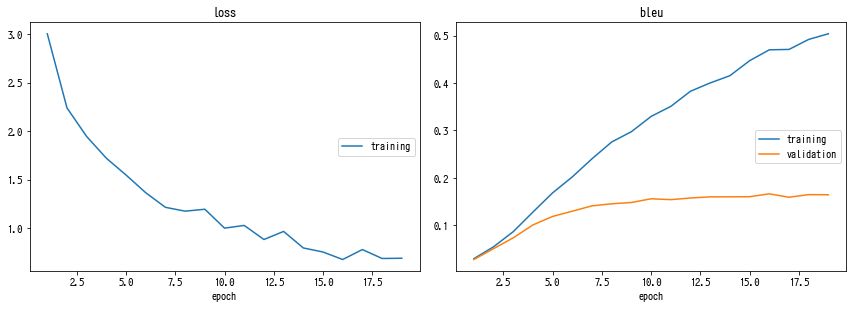

0.16615263000000002

In [30]:
emb_size = 1024
hidden_size = 1024

encoder = EncoderRNN(input_lang.n_words, emb_size, hidden_size).to(device)
decoder = AttnDecoderRNN1(emb_size, hidden_size, output_lang.n_words).to(device)
train_iters(encoder, decoder, batch_size=200, epochs= 20, teacher_forcing=0.9, early_stopping=3)

> i wish you 'd never been born .
= 生まれ て こ な かっ たら よ かっ た ん だ よ 。
< あなた が もっと 恋し かっ たら い い の に なあ 。 <EOS>
bleu: 0.0



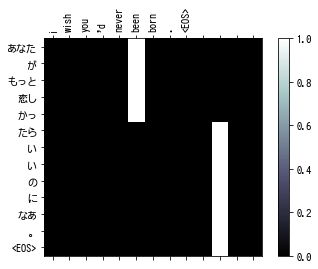

> i could not sleep much last night .
= 昨夜 は ろく に 眠れ な かっ た 。
< 私 は 昨晩 は 眠れ な かっ た 。 <EOS>
bleu: 0.4671



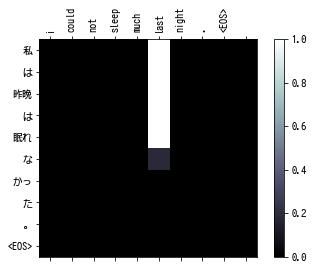

> he is always late for school .
= 彼 は いつ も 学校 に 遅刻 する 。
< 彼 は いつ も 学校 に 遅刻 する 。 <EOS>
bleu: 1.0



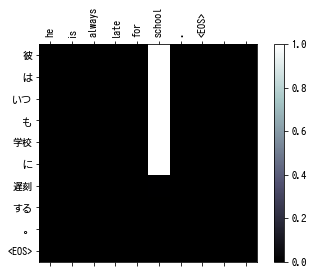

> he is sure to succeed .
= 彼 は 必ず 成功 する 。
< 彼 は きっと 成功 する と い う 。 <EOS>
bleu: 0.0



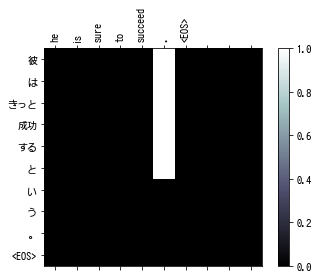

> come into the room after me .
= 私 に つ い て 部屋 に 入 り なさ い 。
< 部屋 の 中 に 入 っ て き て くださ い 。 <EOS>
bleu: 0.0



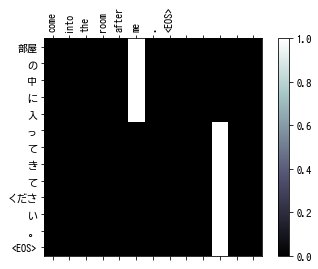

[0.0, 0.4671, 1.0, 0.0, 0.0]

In [31]:
evaluate_randomly(test_pairs, encoder, decoder, n=5)

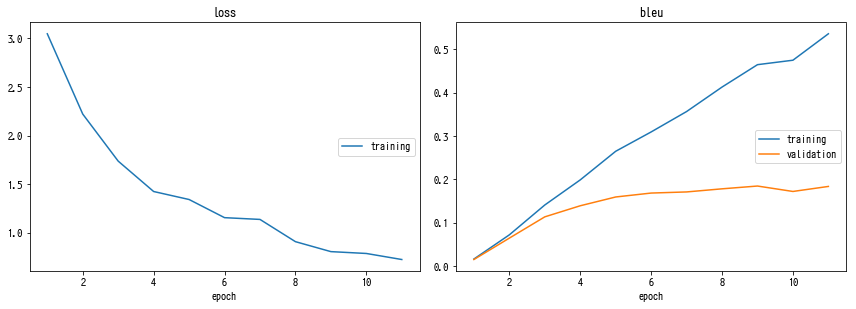

In [ ]:
emb_size = 1024
hidden_size = 1024
attn_size = 1024

encoder = EncoderRNN(input_lang.n_words, emb_size, hidden_size).to(device)
decoder = AttnDecoderRNN2(emb_size, hidden_size, attn_size, output_lang.n_words).to(device)
train_iters(encoder, decoder, batch_size=200, epochs=20, teacher_forcing=0.9, early_stopping=3)

> that week had nothing to do with discrimination .
= その 週間 は 差別 と は 関係 が な かっ た 。
< その 政治 は 何 と 何 も する こと が な かっ た 。 <EOS>
bleu: 0.299



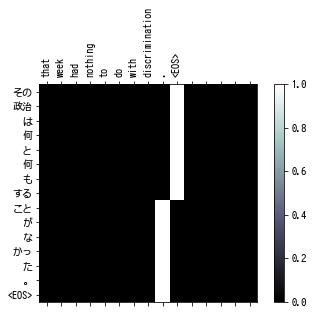

> there was not a cloud in the sky .
= 空 に は 雲 一 つ な かっ た 。
< 空 の 空 に は も な かっ た 。 <EOS>
bleu: 0.3799



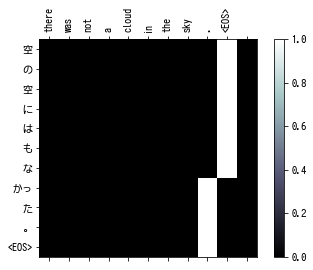

> he goes there every day .
= 彼 は 毎日 そこ へ 行 く 。
< 彼 は 毎日 そこ へ 行 く 。 <EOS>
bleu: 1.0



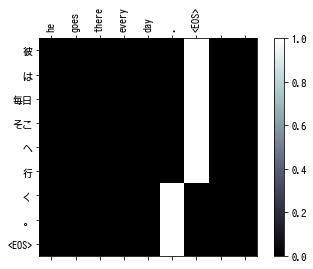

> a few minutes ' walk brought us to the park .
= 数 分歩 い て 私 達 は 公園 へ 来 た 。
< ３ 分歩 分歩 く と 公園 が 着 た 。 <EOS>
bleu: 0.0



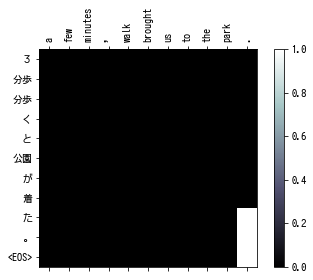

> i think what you say is true .
= おっしゃ る こと は 本当 だ と 思 い ま す 。
< 君 が 言 う と は 本当 だ と 思 う 。 <EOS>
bleu: 0.3318



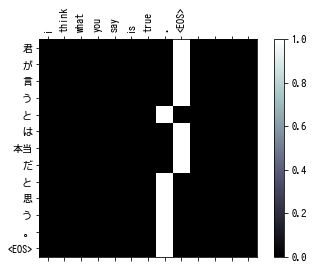

[0.299, 0.3799, 1.0, 0.0, 0.3318]

In [34]:
evaluate_randomly(test_pairs, encoder, decoder, n=5)